# Modeling TF-IDF + LogReg Notebook
**Baseline TF-IDF + Logistic Regression with basic and advanced preprocessed data**

This notebook provides:
1. Data loading & preprocessing (basic mode)
2. TF-IDF vectorization & logistic regression baseline on basic preprocessed data
3. Advanced preprocessing pipeline: Gensim phraser training, advanced cleaning, and full model replication on advanced preprocessed data

The model built on the basic-preprocessed data was developed sequentially—first incorporating cross-validation, then applying χ²-based feature selection, and finally integrating cost-sensitive learning—each enhancement yielding measurable performance gains. These stages serve as templates for subsequent model implementations, with parameters adapted as needed. 

**Model Development Progression:**
- **a) Absolute baseline**: Simple TF-IDF + LogReg with default parameters
- **b) Cross-validation baseline**: Added stratified CV, threshold optimization, and cost-sensitive learning
- **c) GridSearchCV approach**: Manual hyperparameter grid with feature selection
- **d) RandomizedSearchCV approach**: Scalable hyperparameter optimization for template use

**Advanced Preprocessing Pipeline (Part 3):**
- **Gensim Phraser training**: Multiword grouping model is trained on the corpus to detect frequent word combinations (e.g. 'soziale_gerechtigkeit')
- **Advanced cleaning**: Additional domain-specific noise removal, non-alphabetic filtering, stopword removal, and phrase-aware stemming
- **Model replication**: All modeling steps from the basic pipeline are repeated on the advanced preprocessed data for direct comparison

**Final Model Choice**: While GridSearchCV (section c) may achieve slightly better performance on this specific model, we save and recommend the RandomizedSearchCV approach (section d) for its superior scalability, methodology consistency, and adaptability across different model types in comparative studies.

--> **Use as a template**: Exchange model/embedding sections and hyperparameters as needed. The RandomizedSearchCV structure can be easily adapted to any model architecture.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('..'))

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    GroupShuffleSplit,
    cross_val_predict
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2 , mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    make_scorer
)
from joblib import dump
from scipy.stats import loguniform, randint
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    evaluate_thresholds,
    extended_classification_report
)
from src.preprocessing import process_file

## 1) Data Loading & Initial Preprocessing


In [ ]:
# Load and preprocess data (basic mode)
# labeling was performed on already basic cleaned segments 
# but we will clean it again, knowing that the segments might minimally change their structure
df_basiccleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

# Calculate token lengths for each segment
df_basiccleaned['SegmentTokenLength'] = df_basiccleaned['SegmentText'].str.split().str.len()

# Print overall statistics for token lengths
print("Overall SegmentTokenLength stats:\n", df_basiccleaned["SegmentTokenLength"].describe())

# Print statistics for token lengths grouped by parliament
print("\nBy Parliament:\n", df_basiccleaned.groupby("Parliament")["SegmentTokenLength"].describe())
df_basiccleaned.head()

Overall SegmentTokenLength stats:
 count    1000.000000
mean      745.587000
std       320.475036
min        22.000000
25%       470.250000
50%       972.000000
75%      1000.000000
max      1000.000000
Name: SegmentTokenLength, dtype: float64

By Parliament:
             count        mean         std    min     25%     50%     75%  \
Parliament                                                                 
BB          216.0  820.898148  290.793284   39.0  708.50  1000.0  1000.0   
MV           85.0  797.976471  276.943865  148.0  640.00  1000.0  1000.0   
SA          268.0  804.011194  282.805481   43.0  608.75   994.5  1000.0   
SN          275.0  605.196364  353.491280   35.0  236.00   652.0  1000.0   
TH          156.0  759.878205  306.497915   22.0  493.50   966.5  1000.0   

               max  
Parliament          
BB          1000.0  
MV          1000.0  
SA          1000.0  
SN          1000.0  
TH          1000.0  


,DocumentID,SegmentID,Date,Parliament,Description,Links,Filter,SegmentText,Label,SegmentTokenLength
0,SA_100,SA_100_8,02.08.2023,SA,"Aktuelle Daten im PhÃ¤nomenbereich ""Politisch ...",[{'url': 'https://padoka.landtag.sachsen-anhal...,['wittenberg'],"24.11.2021 beimssiedlung 06:35 magdeburg, land...",0,1000
1,BB_189,BB_189_3,16.11.2023,BB,NaN,[{'url': 'https://www.parlamentsdokumentation....,['leag'],im vorfeld der parlamentarischen konferenz mit...,0,134
2,SA_232,SA_232_1,17.11.2023,SA,Ausschussprotokoll Ausschuss fÃ¼r Finanzen 8/F...,[{'url': 'https://padoka.landtag.sachsen-anhal...,"['wasserstoff', 'kraftwerke', 'wärmeplanung', ...",einladung: einladung 8/fin/52 ausschuss für fi...,0,1000
3,SA_140,SA_140_1,29.08.2023,SA,Gewaltschutz und Hilfssysteme im Sinne der Ist...,[{'url': 'https://padoka.landtag.sachsen-anhal...,['lauchstädt'],dokument: drucksache 8/3052 öffentlich antrag ...,0,707
4,SA_372,SA_372_1,14.03.2024,SA,Ausschussprotokoll Ausschuss fÃ¼r Petitionen 8...,[{'url': 'https://padoka.landtag.sachsen-anhal...,['wittenberg'],einladung: einladung 8/pet/39 öffentlich aussc...,0,439


## 2) Baseline: TF-IDF + Logistic Regression
Standard train/test split, threshold = 0.5.

In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

**a) absolute baseline**

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       146
           1       1.00      0.20      0.34        54

    accuracy                           0.79       200
   macro avg       0.89      0.60      0.61       200
weighted avg       0.83      0.79      0.73       200

Additional Metrics:
Accuracy   0.785
F2-score   0.242
AUC-ROC    0.841
AUC-PR     0.741



c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Text(0.5, 1.0, 'Metric Scores vs Classification Threshold')

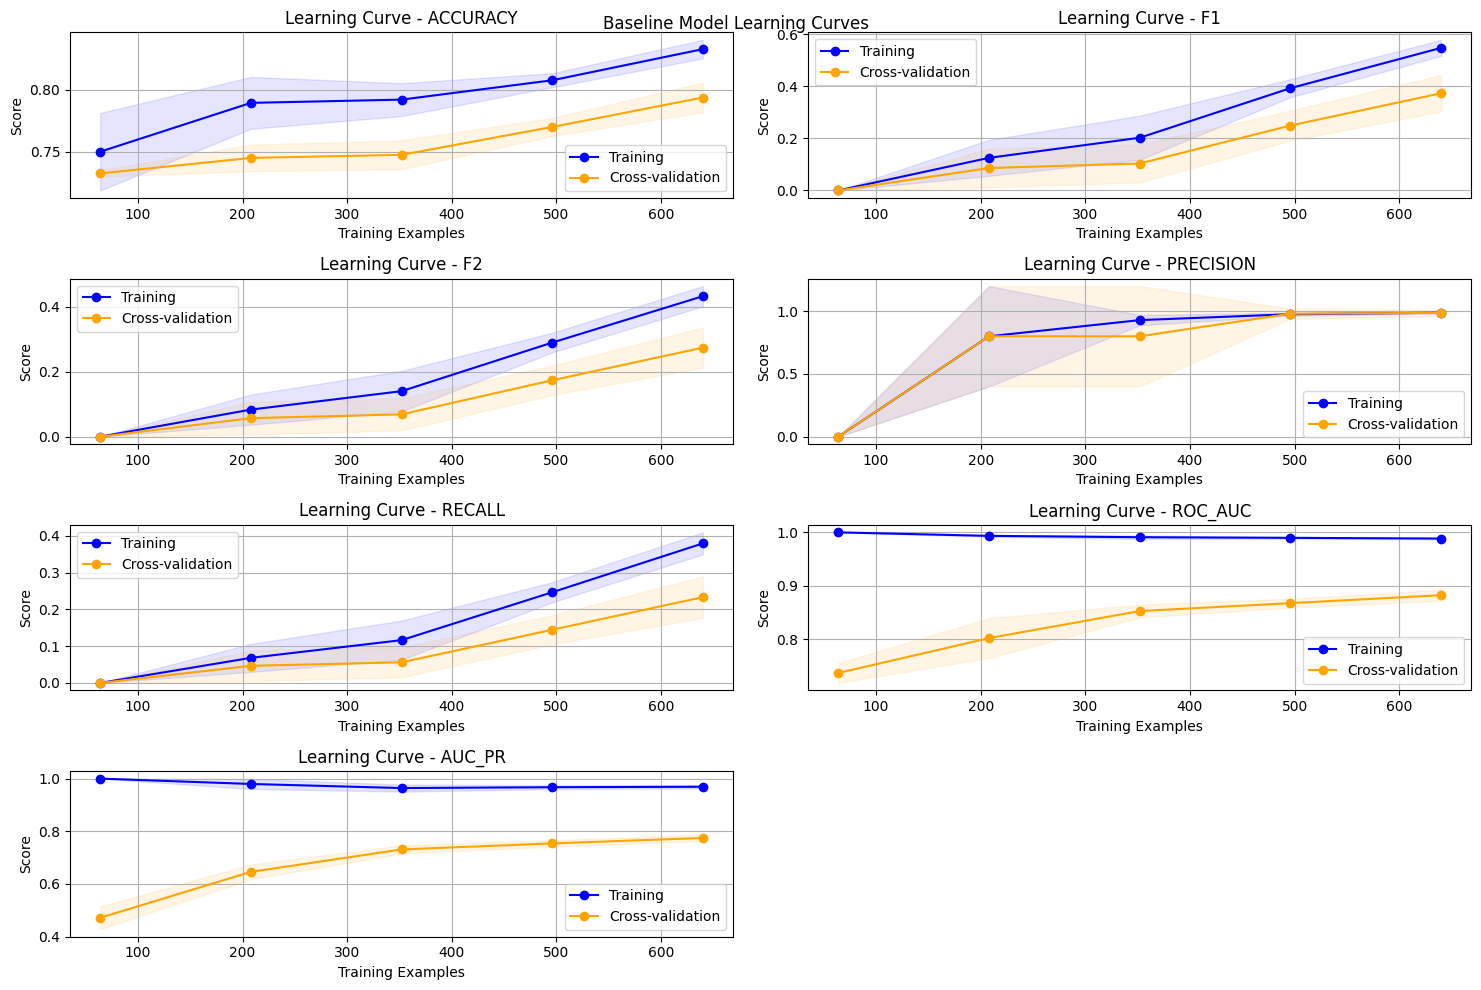

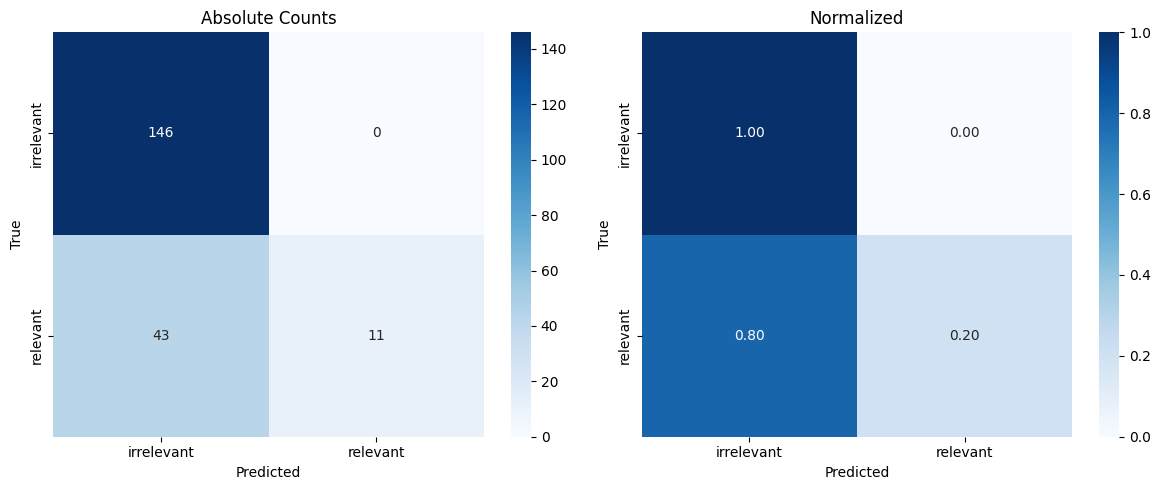

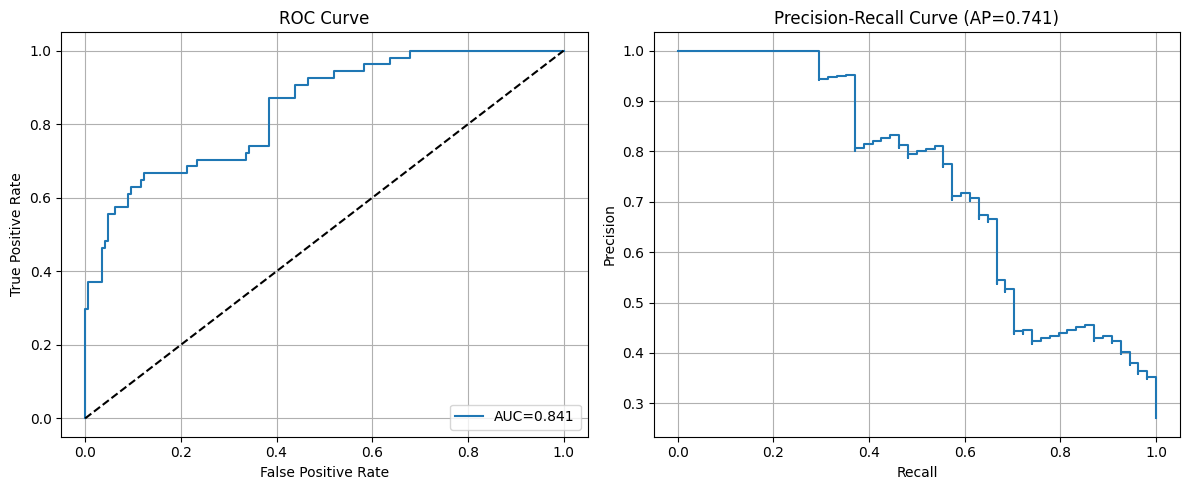

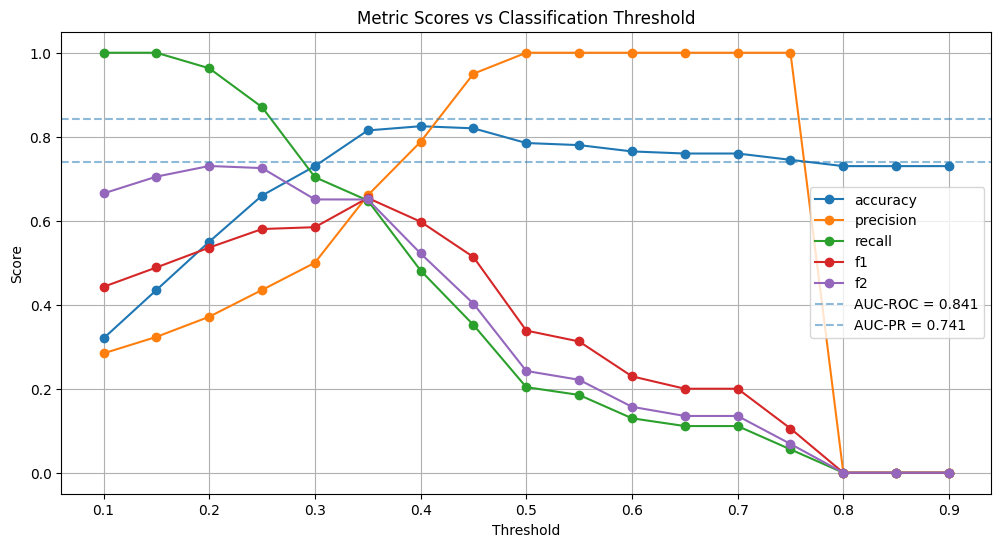

In [8]:
#define baseline model pipeline
pipeline_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", LogisticRegression(solver="liblinear", random_state=42))
])

# Fit baseline and get predictions
pipeline_baseline.fit(X_dev, y_dev)
y_pred = pipeline_baseline.predict(X_test)
y_pred_proba = pipeline_baseline.predict_proba(X_test)

# Basic evaluation on our metrics
print("Baseline Model Performance:")
print(extended_classification_report(y_test, y_pred, y_pred_proba[:, 1]))

# Evaluation
# Learning Curves (Multi-Metric Analysis)
# Using all metrics including F2, ROC-AUC, and AUC-PR
plot_learning_curves(pipeline_baseline, X_dev, y_dev, 
                    cv=5,
                    figsize=(15, 10))
plt.suptitle('Baseline Model Learning Curves')

# Confusion Matrix (Absolute and Normalized)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_pred, normalize=False, ax=ax1, 
                     title='Absolute Counts')
plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax2,
                     title='Normalized')
plt.tight_layout()

# ROC and Precision-Recall Analysis
plot_roc_and_pr_curves(y_test, y_pred_proba[:, 1])

# Threshold Analysis and Visualization
threshold_results = evaluate_thresholds(y_test, y_pred_proba[:, 1])
plot_threshold_curves(threshold_results)
plt.title('Metric Scores vs Classification Threshold')

**b) baseline with stratified cross validation**
- during development we recognised the necessity to choose a treshhold because of data imbalance and the importance of recall over precision. 
- we did so by using the `cross_val_predict`method and optimizing the treshhold for the f2 score
- final model and treshhold are used on the test_data

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'clf__C': 10, 'clf__class_weight': {0: 1, 1: 100}}
Best F2 score during CV: 0.802

Generating out-of-fold predictions for threshold tuning...

Tuning threshold on dev set...


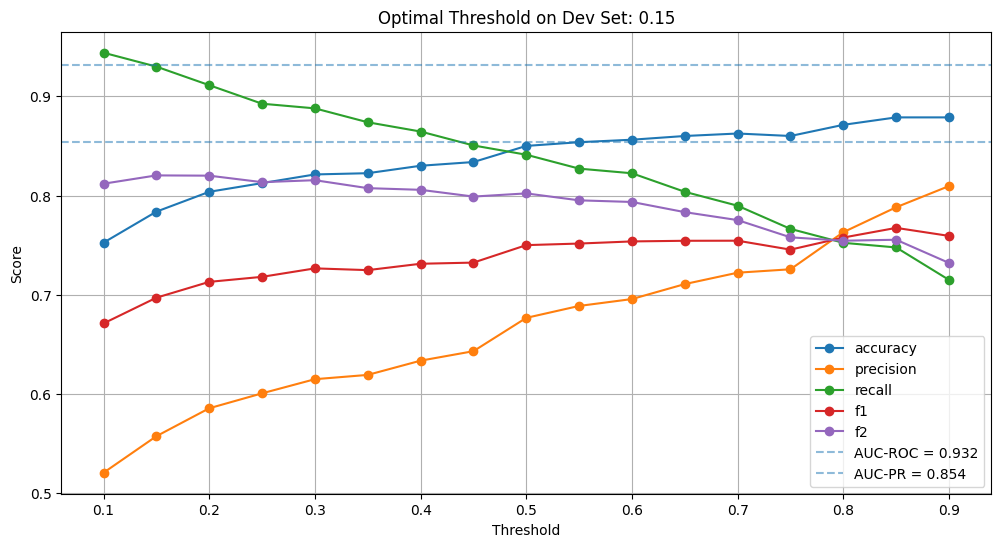

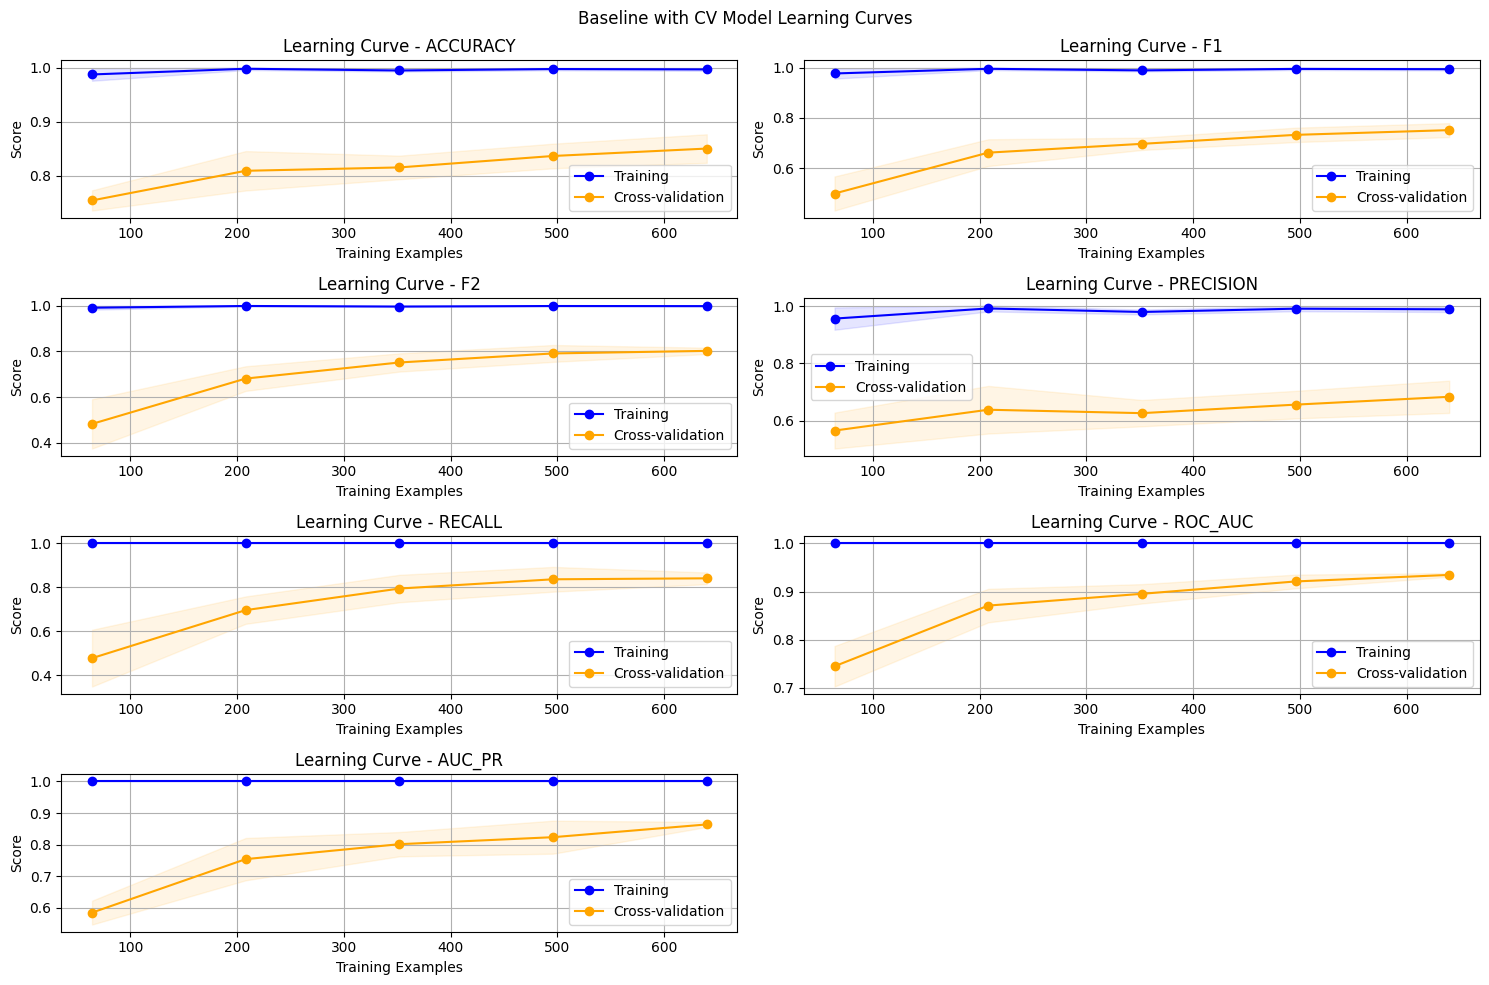


Final Evaluation on Test Set:

Final Threshold: 0.15

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       146
           1       0.49      0.87      0.63        54

    accuracy                           0.72       200
   macro avg       0.71      0.77      0.71       200
weighted avg       0.81      0.72      0.74       200

Additional Metrics:
Accuracy   0.725
F2-score   0.756
AUC-ROC    0.870
AUC-PR     0.749



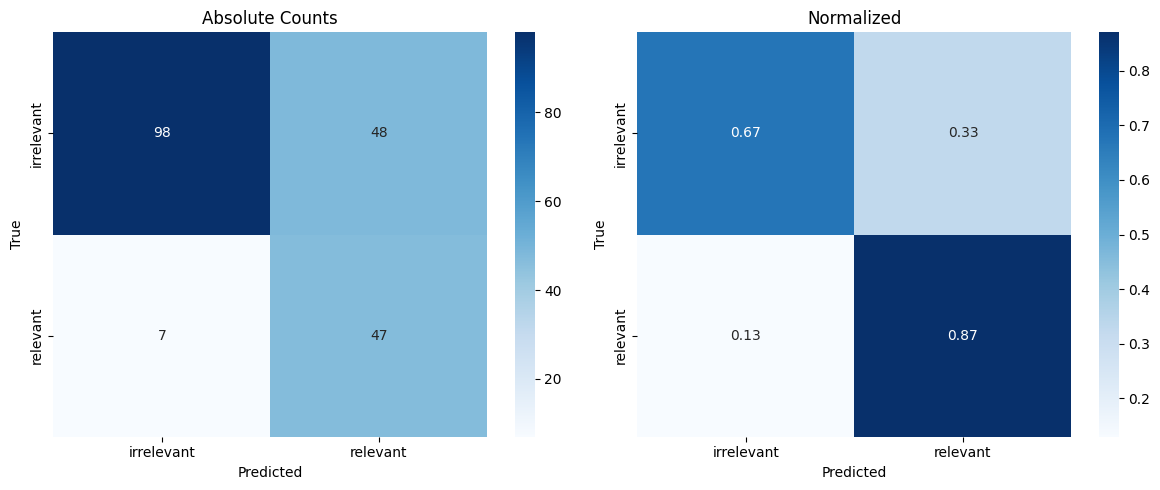

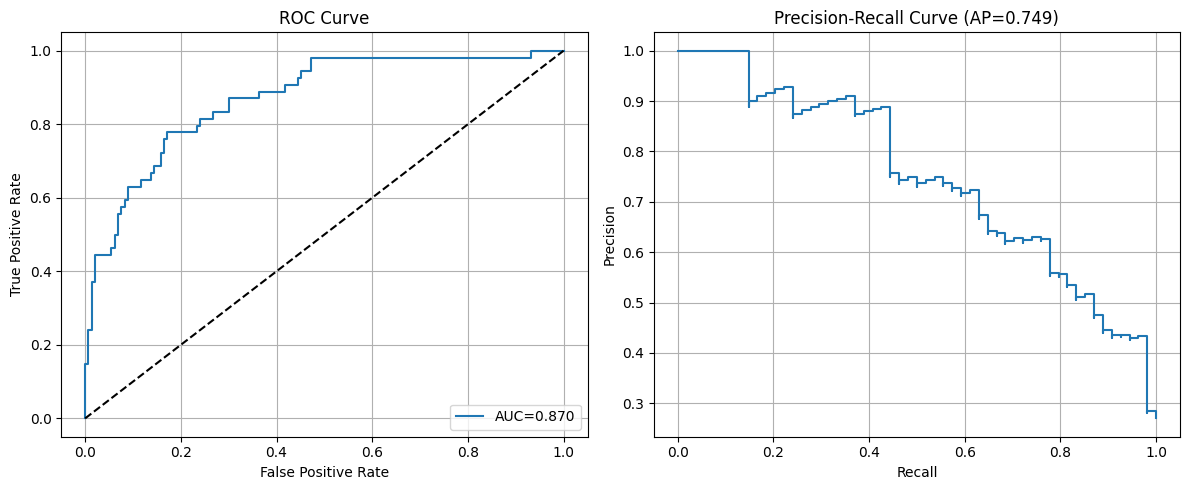

In [9]:
# Define a Pipeline for training via cross-validation with lasso regularization and class_weight
pipeline_cv_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf",  LogisticRegression(solver="liblinear", penalty="l1", class_weight="balanced", random_state=42))
])

# penalty parameter grid for cross-validation
param_grid_cv_baseline = {
    "clf__C": [0.01, 0.1, 1, 10, 25, 50], 
    "clf__class_weight": ["balanced",  {0:1, 1:90}, {0:1, 1:100}, {0:1, 1:110}]
}

# Create F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_cv_baseline = GridSearchCV(
    pipeline_cv_baseline,
    param_grid_cv_baseline,
    cv=cv,
    scoring=f2_scorer,  # using custom F2 scorer
    n_jobs=-1,
    verbose=1
)

# Fit cv_baseline and get predictions
grid_cv_baseline.fit(X_dev, y_dev)

# Get best parameters and score
print("Best parameters:", grid_cv_baseline.best_params_)
print(f"Best F2 score during CV: {grid_cv_baseline.best_score_:.3f}")

# Get the best model from the grid search
model_cv_baseline = grid_cv_baseline.best_estimator_

# Get out-of-fold predictions on dev set for threshold tuning
print("\nGenerating out-of-fold predictions for threshold tuning...")
y_dev_proba = cross_val_predict(
    model_cv_baseline, X_dev, y_dev,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:,1]

# Threshold tuning on dev set
print("\nTuning threshold on dev set...")
dev_thresh_results = evaluate_thresholds(y_dev, y_dev_proba)
# Optimize for F2 score
best_threshold = max(dev_thresh_results, key=lambda r: r["f2"])["threshold"]
plot_threshold_curves(dev_thresh_results)
plt.title(f'Optimal Threshold on Dev Set: {best_threshold:.2f}')
plt.show()

# Learning Curves Analysis
plot_learning_curves(model_cv_baseline, X_dev, y_dev, 
                    cv=cv,
                    figsize=(15, 10))
plt.suptitle('Baseline with CV Model Learning Curves')
plt.tight_layout()
plt.show()

print("\nFinal Evaluation on Test Set:")

# Get predictions on test set using optimal threshold
y_test_proba = model_cv_baseline.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print(f"\nFinal Threshold: {best_threshold:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

# Final visualizations on test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, 
                     title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True, ax=ax2,
                     title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall Analysis (only for final evaluation)
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()


**c) final model TF-IDF LogReg with basic preprocessed data**
- we build on findings from b) and try to minimize noise/overfitting/large penalty terms
- we do that by implementing an filtering method (chi-squared-filtering) to only keep most relevant vectors for our prediction
- implement the filter into our grid-search

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'clf__C': 10, 'clf__class_weight': {0: 1, 1: 15}, 'select__k': 100}
Best F2 score during CV: 0.847

Generating out-of-fold predictions for threshold tuning...

Tuning threshold on dev set...


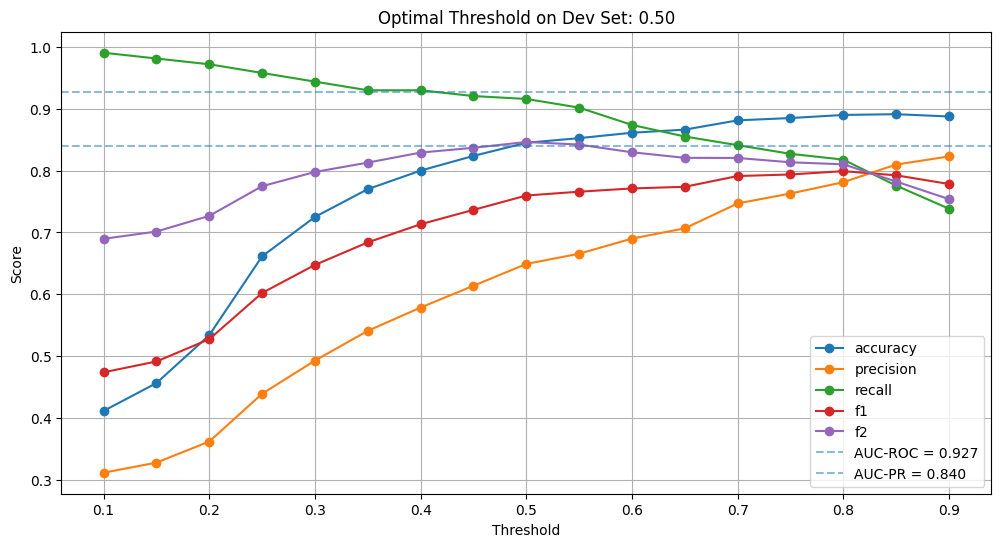

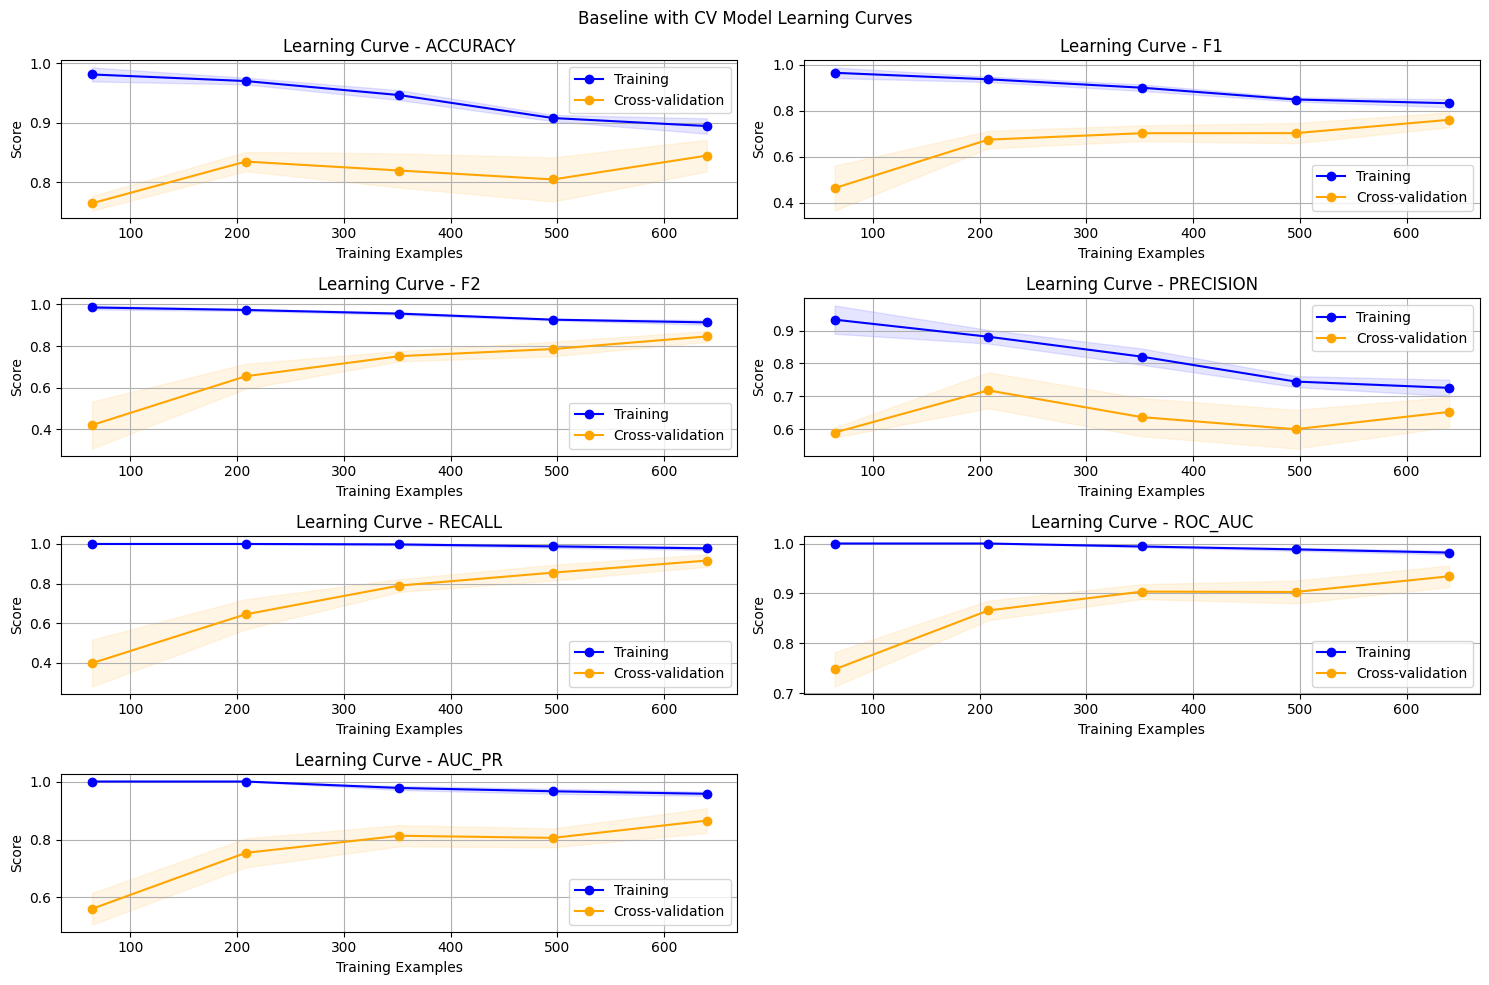


Final Evaluation on Test Set:

Final Threshold: 0.50

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       146
           1       0.65      0.87      0.75        54

    accuracy                           0.84       200
   macro avg       0.80      0.85      0.81       200
weighted avg       0.87      0.84      0.85       200

Additional Metrics:
Accuracy   0.840
F2-score   0.816
AUC-ROC    0.917
AUC-PR     0.822



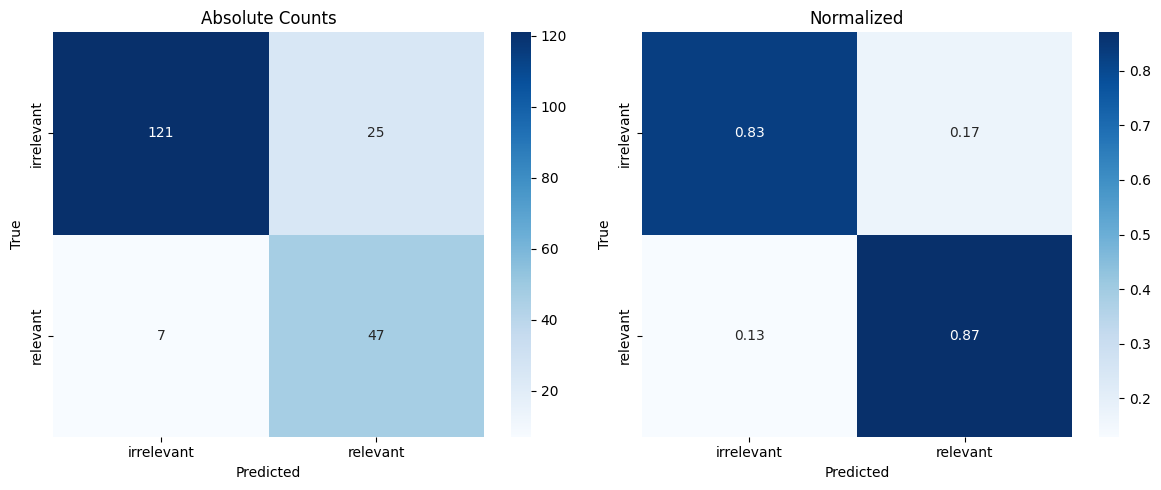

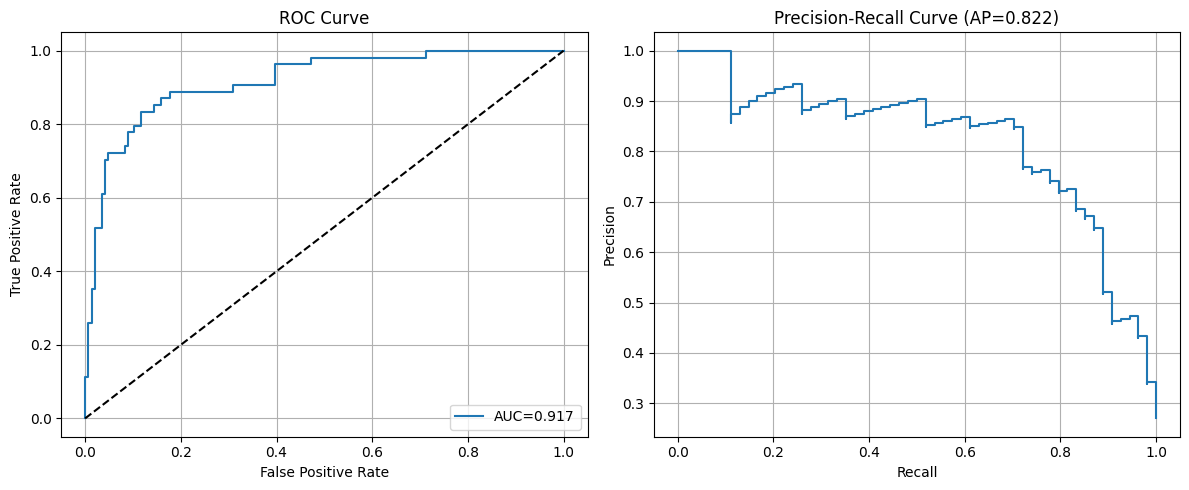

In [6]:
# Define a Pipeline for tfidf vectorization, lasso regularization, class_weight for cost-sensitive learning, and feature selection via chi2
pipeline_tfidf_logreg = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("select", SelectKBest(score_func=chi2, k=2000)),
    ("clf",  LogisticRegression(solver="liblinear", penalty="l1", class_weight="balanced", random_state=42))
])

# penalty parameter grid for cross-validation
param_grid_tfidf_logreg = {
    "clf__C": [1, 10, 20],
    "select__k": [50, 100, 150], 
    "clf__class_weight": ["balanced",  {0:1, 1:5}, {0:1, 1:15}, {0:1, 1:20}]
}

# Create F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# stratified 5-fold cross-validation for training
# using StratifiedKFold to maintain class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_tfidf_logreg = GridSearchCV(
    pipeline_tfidf_logreg,
    param_grid_tfidf_logreg,
    cv=cv,
    scoring=f2_scorer,  # using custom F2 scorer
    n_jobs=-1,
    verbose=1
)

# Fit cv_baseline and get predictions
grid_tfidf_logreg.fit(X_dev, y_dev)

# Get best parameters and score
print("Best parameters:", grid_tfidf_logreg.best_params_)
print(f"Best F2 score during CV: {grid_tfidf_logreg.best_score_:.3f}")

# Get the best model from the grid search
model_tfidf_logreg_basic = grid_tfidf_logreg.best_estimator_

# Get out-of-fold predictions on dev set for threshold tuning
print("\nGenerating out-of-fold predictions for threshold tuning...")
y_dev_proba = cross_val_predict(
    model_tfidf_logreg_basic, X_dev, y_dev,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:,1]

# Threshold tuning on dev set
print("\nTuning threshold on dev set...")
dev_thresh_results = evaluate_thresholds(y_dev, y_dev_proba)
# Optimize for F2 score
best_threshold = max(dev_thresh_results, key=lambda r: r["f2"])["threshold"]
plot_threshold_curves(dev_thresh_results)
plt.title(f'Optimal Threshold on Dev Set: {best_threshold:.2f}')
plt.show()

# Learning Curves Analysis
plot_learning_curves(model_tfidf_logreg_basic, X_dev, y_dev, 
                    cv=cv,
                    figsize=(15, 10))
plt.suptitle('Baseline with CV Model Learning Curves')
plt.tight_layout()
plt.show()

print("\nFinal Evaluation on Test Set:")

# Get predictions on test set using optimal threshold
y_test_proba = model_tfidf_logreg_basic.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print(f"\nFinal Threshold: {best_threshold:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

# Final visualizations on test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, 
                     title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True, ax=ax2,
                     title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall Analysis (only for final evaluation)
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()


**d) final model with randomizedsearchcv instead of gridsearch** 

**Why RandomizedSearchCV over GridSearchCV?**

While GridSearchCV (section c) might achieve slightly better performance on this specific TF-IDF + LogReg combination, we implement RandomizedSearchCV here for several strategic reasons:

1. **Template Scalability**: This approach can be easily adapted to any model type (neural networks, SVMs, ensemble methods) without manually crafting parameter grids for each model
2. **Hyperparameter Space Exploration**: Continuous distributions (like `loguniform`) explore a much larger parameter space than discrete grids, potentially finding better configurations
3. **Computational Efficiency**: For complex models with many hyperparameters, RandomizedSearch scales better than exhaustive grid search
4. **Consistent Methodology**: Using the same hyperparameter optimization approach across all models ensures fair comparison

**Trade-off Justification**: We accept potentially slightly lower performance on this specific model to gain significant advantages in methodology consistency, scalability, and reproducibility across our entire model comparison framework. This approach aligns with best practices for systematic model evaluation in academic research.

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\tdoro\miniconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'clf__C': np.float64(6.220638781359818), 'clf__class_weight': {0: 1, 1: 9}, 'select__k': 135}
Best F2 score during CV: 0.821


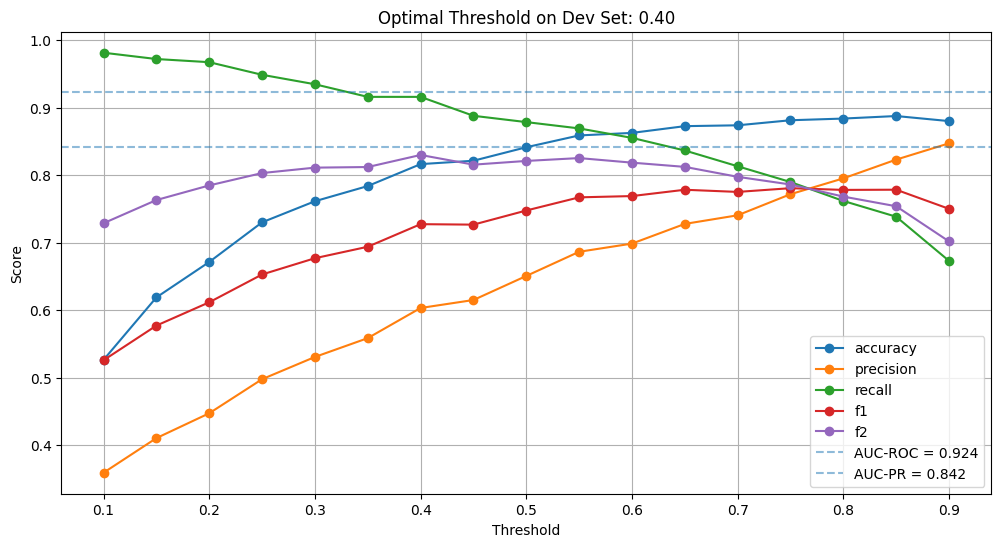

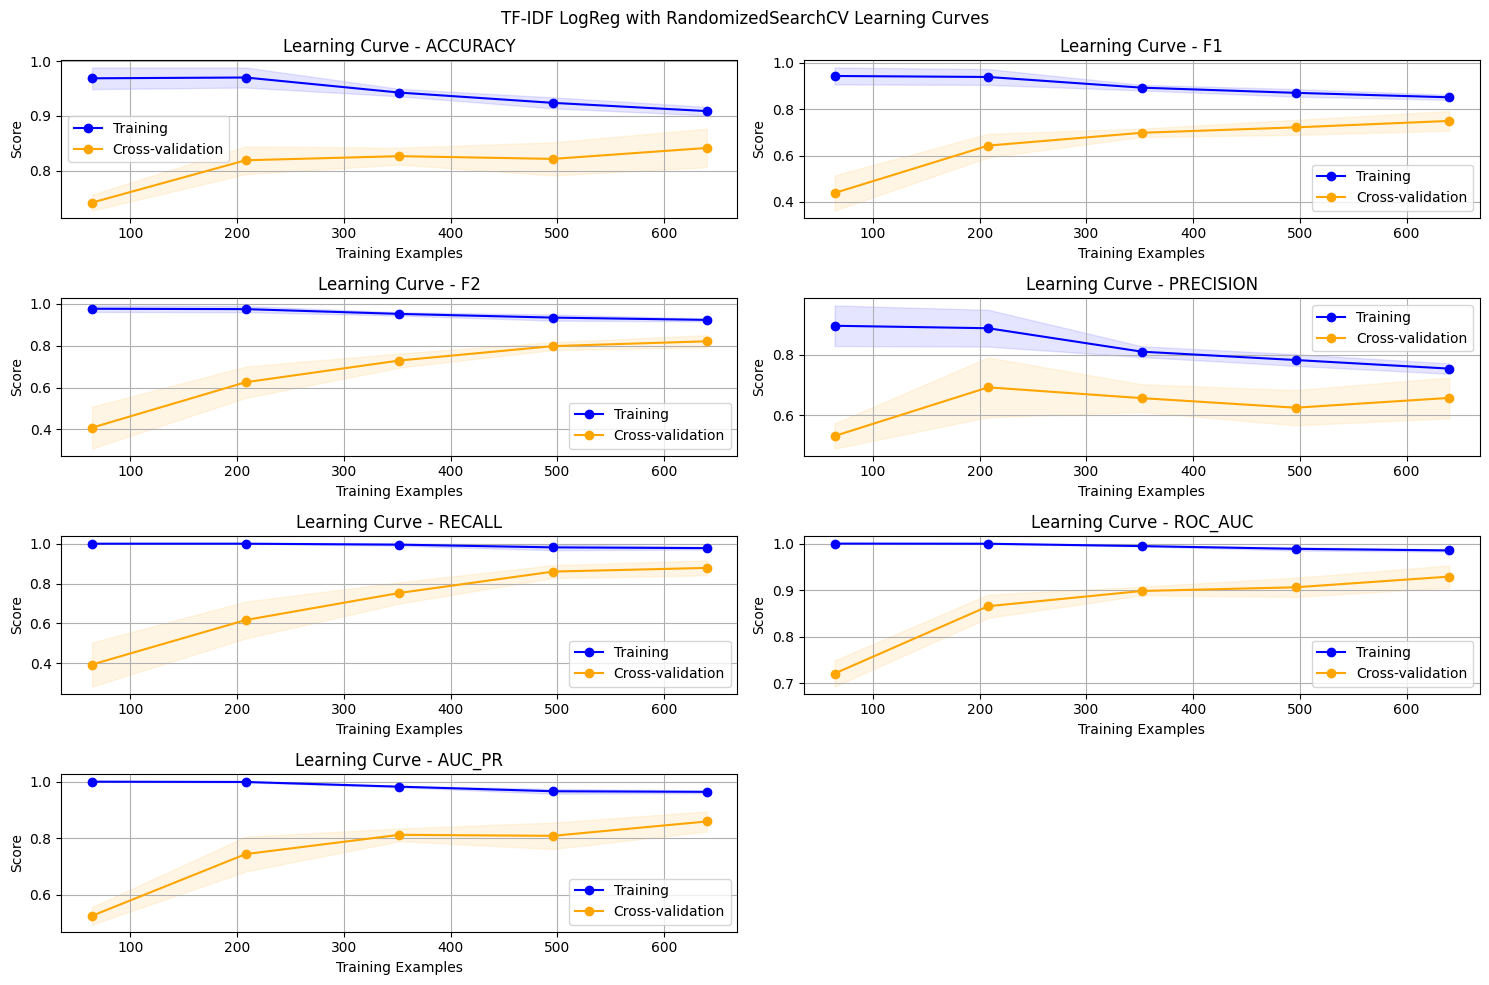


Final Threshold: 0.40

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       146
           1       0.62      0.85      0.72        54

    accuracy                           0.82       200
   macro avg       0.78      0.83      0.79       200
weighted avg       0.85      0.82      0.83       200

Additional Metrics:
Accuracy   0.820
F2-score   0.793
AUC-ROC    0.896
AUC-PR     0.787



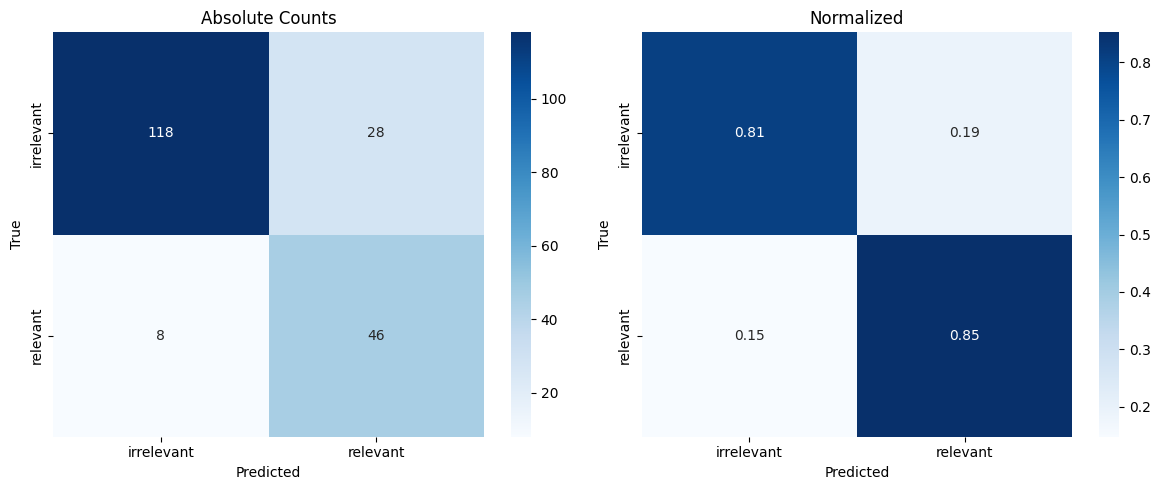

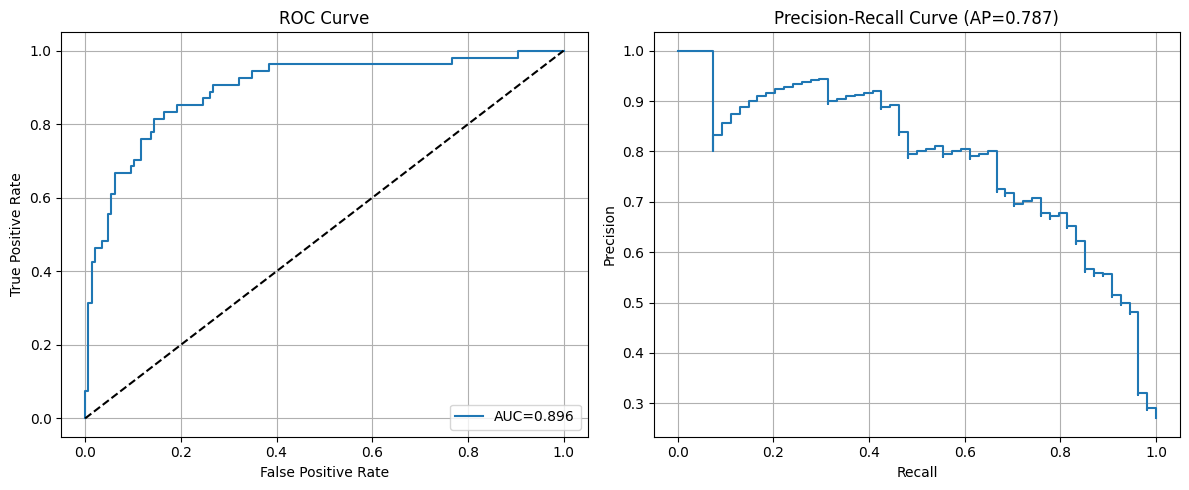


Model saved as 'model_tfidf_logreg_basic.joblib'


In [5]:
# Base Pipeline 
pipeline_tfidf_logreg = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     LogisticRegression(
                    solver="liblinear",
                    penalty="l1",
                    class_weight="balanced",
                    random_state=42
                ))
])

# Hyperparameter Distributions for Random Search
# This approach scales better to different model types
weights = ["balanced"] + [{0:1, 1:w} for w in range(1, 31, 2)]
param_dist_tfidf_logreg = {
    "clf__C":            loguniform(1e-3, 1e3),      # C ∈ [1e-3, 1e3]
    "select__k":         randint(50, 151),           # k ∈ {50, …, 150}
    "clf__class_weight": weights  # class weights for cost-sensitive learning
}

# F2 Scorer and CV Strategy
f2_scorer = make_scorer(fbeta_score, beta=2)
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV (100 random configurations)
# Advantage: Easily adaptable to different models without manual grid tuning
rand_search = RandomizedSearchCV(
    estimator         = pipeline_tfidf_logreg,
    param_distributions = param_dist_tfidf_logreg,
    n_iter            = 100,
    cv                = cv,
    scoring           = f2_scorer,
    n_jobs            = -1,
    random_state      = 42,
    verbose           = 1,
    return_train_score=True
)

# Execute search
rand_search.fit(X_dev, y_dev)
print("Best parameters:", rand_search.best_params_)
print(f"Best F2 score during CV: {rand_search.best_score_:.3f}")

# Extract best model
model_tfidf_logreg_basic = rand_search.best_estimator_

# Out-of-fold predictions for threshold tuning
y_dev_proba = cross_val_predict(
    model_tfidf_logreg_basic, X_dev, y_dev,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Threshold tuning on dev set (optimized for F2)
dev_thresh_results = evaluate_thresholds(y_dev, y_dev_proba)
best_threshold   = max(dev_thresh_results, key=lambda r: r["f2"])["threshold"]
plot_threshold_curves(dev_thresh_results)
plt.title(f'Optimal Threshold on Dev Set: {best_threshold:.2f}')
plt.show()

# Learning curves analysis
plot_learning_curves(
    model_tfidf_logreg_basic, X_dev, y_dev,
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LogReg with RandomizedSearchCV Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set
y_test_proba = model_tfidf_logreg_basic.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= best_threshold).astype(int)

print(f"\nFinal Threshold: {best_threshold:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Save the RandomizedSearch model (preferred for template/comparison purposes)
# This approach is more generalizable across different model types
dump({
    'model': model_tfidf_logreg_basic,
    'threshold': best_threshold,
    'cv_score': rand_search.best_score_,
    'best_params': rand_search.best_params_,
    'search_type': 'RandomizedSearchCV'
}, "model_tfidf_logreg_basic.joblib")

print(f"\nModel saved as 'model_tfidf_logreg_basic.joblib'")


**Some experimental visualizations**

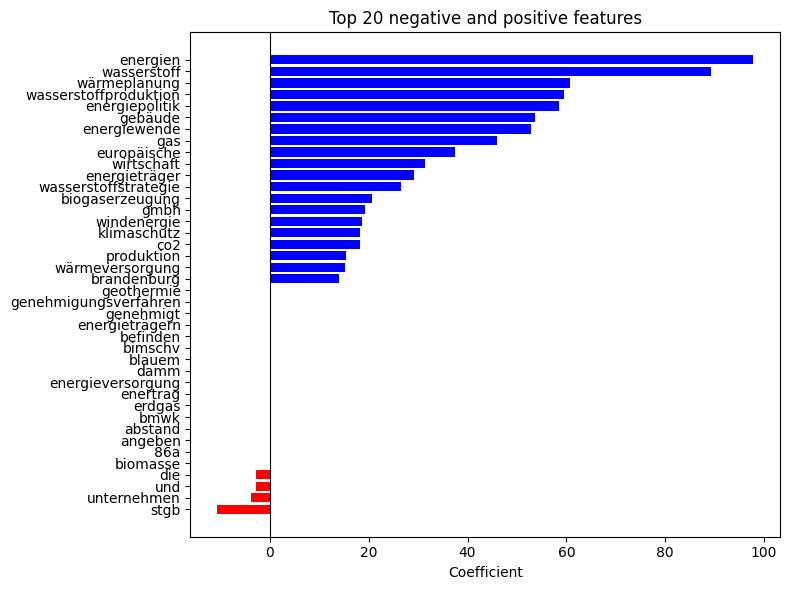

In [ ]:
from joblib import load

# load model
data = load("model_tfidf_logreg_basic.joblib")
model      = data['model']
threshold  = data['threshold']
cv_score   = data['cv_score']
best_params= data['best_params']

# plot coefficients
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tfidf  = model.named_steps['tfidf']
select = model.named_steps['select']
clf    = model.named_steps['clf']

all_feats = tfidf.get_feature_names_out()
sel_feats = all_feats[select.get_support()]
coefs     = clf.coef_[0]

df_coef = pd.DataFrame({'feature': sel_feats, 'coef': coefs}).sort_values('coef')
neg20 = df_coef.head(20)
pos20 = df_coef.tail(20)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(neg20['feature'], neg20['coef'], color='red')
ax.barh(pos20['feature'], pos20['coef'], color='blue')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Top 20 negative and positive features')
ax.set_xlabel('Coefficient')
plt.tight_layout()
plt.show()


## 3) TF-IDF + Logistic Regression on advanced preprocessing


First we have to design our advanced preprocessing pipeline and add is as a Module to src. 
- clean more noise (gathered as insights during labeling process)
- remove non alpha characters 
- multiword-grouping (as a improved form of 2-gramming)
- stop word removal
- stemming

**After that, we replicate our steps from section 2) of this notebook on advanced preprocessed data**

**a) We need to train the gensim-phraser on our corpus for multiword grouping in the advanced preprocessing pipeline**

We use the resulting `bigram.pkl` as the trained gensim phraser for multiword-grouping (sort of improved 2-gramming) in the `src.preprocessing.py` module

In [57]:
from src.phrase_trainer import train_phrases

# a) Load raw texts
df_raw = pd.read_csv('../05modeling_pipelines/1klabeled_segments.csv', usecols=['SegmentText'])
raw_texts = df_raw['SegmentText'].tolist()

# b) Train phraser
#treshhold and min_count chosen based on exploratory analysis 
#(ca. 1% of corpus as multiword_groups) and can be interpreted as an educated guess, chosen after some experimentation
bigram = train_phrases(raw_texts, min_count=10, threshold=300.0) 

bigram.save('bigram.pkl')

# c) Extract and analyze top phrases
phrase_scores = bigram.phrasegrams      # Dict[(word1, word2) -> score]

# Build list of records from phrasegrams dict
records = [
    {'phrase': phrase, 'score': score}
    for phrase, score in bigram.phrasegrams.items()
]

# Convert to DataFrame and sort by score in descending order
df_phrases = (
    pd.DataFrame(records)
      .sort_values('score', ascending=False)
      .reset_index(drop=True)
)


print(df_phrases.count())
print(df_phrases.head(50))
print(df_phrases.tail(50))

phrase    605
score     605
dtype: int64
                                     phrase        score
0                           sarah_buddeberg  8378.076316
1                       referentin_referent  8092.114379
2                beratungsdienst_referentin  8092.114379
3                            monika_hohmann  8056.213251
4                     gemeindename_wählende  7997.622609
5                            acrobat_reader  7979.120301
6                              nicole_anger  7936.496795
7                        hansjürgen_zickler  7860.911111
8          gesetzgebungsund_beratungsdienst  7803.110294
9                          treibhausgas_thg  7690.021739
10                          susanne_schaper  7580.164286
11                          claudia_maicher  7369.604167
12                       antonia_mertsching  7134.272269
13                         annemarie_keding  7096.655864
14                    gunnar_schellenberger  7038.099481
15                 landtagsgebäude_domplatz  70

**b) replicating modeling steps on advanced preprocessing pipeline**

In [4]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

# Calculate token lengths for each segment
df_advancedcleaned['SegmentTokenLength'] = df_advancedcleaned['SegmentText'].str.split().str.len()

# Print overall statistics for token lengths
print("Overall SegmentTokenLength stats:\n", df_advancedcleaned["SegmentTokenLength"].describe())

# Print statistics for token lengths grouped by parliament
print("\nBy Parliament:\n", df_advancedcleaned.groupby("Parliament")["SegmentTokenLength"].describe())
df_advancedcleaned.tail()

Overall SegmentTokenLength stats:
 count    1000.00000
mean      390.35200
std       173.89278
min        10.00000
25%       246.75000
50%       458.50000
75%       523.00000
max       951.00000
Name: SegmentTokenLength, dtype: float64

By Parliament:
             count        mean         std   min     25%    50%     75%    max
Parliament                                                                   
BB          216.0  423.319444  156.328559  24.0  366.00  487.0  530.00  654.0
MV           85.0  415.164706  150.591441  86.0  345.00  460.0  511.00  923.0
SA          268.0  426.511194  162.197006  32.0  329.75  479.0  531.00  951.0
SN          275.0  321.992727  193.083035  19.0  120.50  331.0  518.00  701.0
TH          156.0  389.570513  158.365568  10.0  254.50  446.0  519.25  663.0


,DocumentID,SegmentID,Date,Parliament,Description,Links,Filter,SegmentText,Label,SegmentTokenLength
995,SA_107,SA_107_1,09.08.2023,SA,"Nah- und FernwÃ¤rmenetze in Sachsen-Anhalt, Kl...",[{'url': 'https://padoka.landtag.sachsen-anhal...,"['erdgas', 'wasserstoff', 'biogas', 'biomethan...",dokument gemeind sachsenanhalt gibt nahund fer...,1,560
996,MV_571,MV_571_1,14.04.2025,MV,Gesetz über die Feststellung eines Nachtrags z...,[{'url': 'https://www.dokumentation.landtag-mv...,"['kommunale haushalte', 'energiepreis']",mecklenburgvorpomm beschlussempfehl finanzauss...,1,345
997,SA_639,SA_639_8,20.11.2024,SA,Plenarprotokoll 8/77 20.11.2024 S. 1-190,[{'url': 'https://padoka.landtag.sachsen-anhal...,"['wasserstoff', 'lng', 'kraftwerke', 'wittenbe...",cdu zuruf afd lieb afd ja schwarzgelb jahr sch...,0,470
998,SN_1595,SN_1595_1,01.04.2025,SN,"Krankenhausförderung im Freistaat Sachsen, Pau...",[{'url': 'https://edas.landtag.sachsen.de/reda...,"['wärmeplanung', 'haushaltssicherung']",klanfr franziska_schubert bundnisgrun drs sach...,0,544
999,SN_487,SN_487_1,02.01.2024,SN,"""Gefährliche Orte, ""Kontrollstellen"", ""Kontrol...",[{'url': 'https://edas.landtag.sachsen.de/reda...,['heitmüller'],klanfr julian_nagel link drs sachsisch klein_a...,0,154


**some statistics to gain insights on advanced preprocessed data/influence of advanced preprocessing**

In [7]:
# Simple corpus statistics from segmented data
from collections import Counter
import re

# Extract all tokens from segmented texts
all_tokens = []
for text in df_advancedcleaned['SegmentText']:
    # Remove non-alphabetic characters (keep German umlauts)
    cleaned = re.sub(r"[^a-zäöüß\s]+", " ", text)
    
    # Remove extra whitespace
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    # Tokenize (whitespace) and filter tokens with more than 1 character
    tokens = [t for t in cleaned.split() if len(t) > 1]
    all_tokens.extend(tokens)

# Count term frequencies
term_freq = Counter(all_tokens)

# Basic statistics
total_docs = len(df_advancedcleaned)
total_tokens = len(all_tokens)
vocab_size = len(term_freq)

print(f"Documents: {total_docs}")
print(f"Total tokens: {total_tokens}")
print(f"Vocabulary size (Unique tokens): {vocab_size}")
print(f"Avg tokens per document: {total_tokens/total_docs:.1f}")

# Create frequency dataframe
df_advancedcleaned_termfreq = pd.DataFrame([
    {'term': term, 'frequency': freq}
    for term, freq in term_freq.items()
]).sort_values('frequency', ascending=False).reset_index(drop=True)

# Show top 30 most frequent terms
print("\nTop 30 frequent terms:")
print(df_advancedcleaned_termfreq.head(30))

# Show top 30 least frequent terms
print("\nTop 30 least frequent terms:")
print(df_advancedcleaned_termfreq.tail(30))





Documents: 1000
Total tokens: 406244
Vocabulary size (Unique tokens): 41760
Avg tokens per document: 406.2

Top 30 frequent terms:
             term  frequency
0            jahr       2242
1            frag       2204
2            wurd       1897
3            land       1708
4            stgb       1708
5              ja       1679
6    landesregier       1618
7           stadt       1520
8            sowi       1416
9     brandenburg       1320
10           bitt       1214
11            afd       1151
12           herr       1088
13        thuring       1080
14            sei       1071
15      sachsisch       1062
16     abgeordnet       1031
17  sachsenanhalt       1025
18           prev       1009
19         antrag       1000
20       massnahm        997
21         offent        986
22           nein        969
23      landkreis        968
24        antwort        962
25          sachs        951
26             pi        924
27           viel        916
28           link        901

**perform train-test split**

In [8]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

**train and evaluate model on advanced preprocessed data**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'clf__C': 9.89769666184624, 'clf__class_weight': {0: 1, 1: 21}, 'select__k': 135}
Best F2 score during CV: 0.851


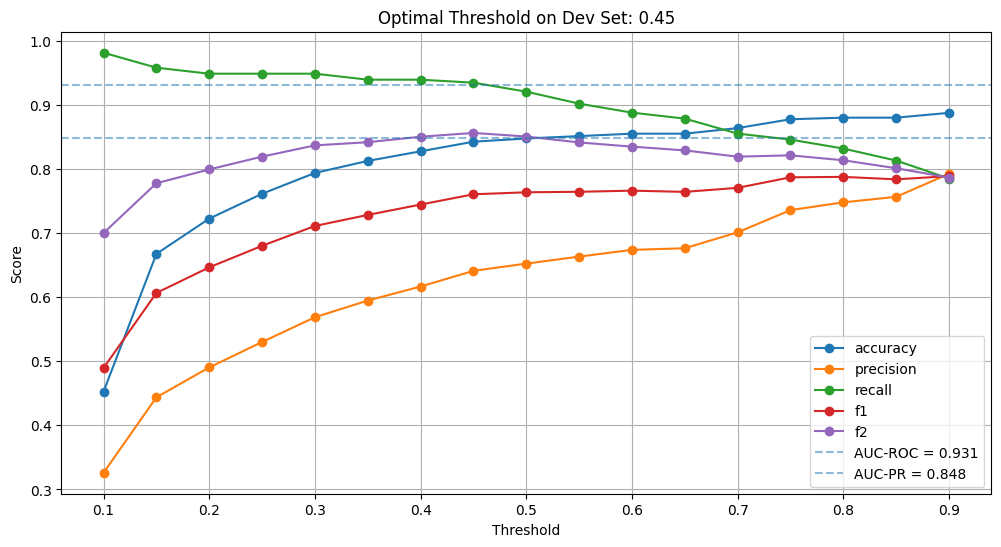

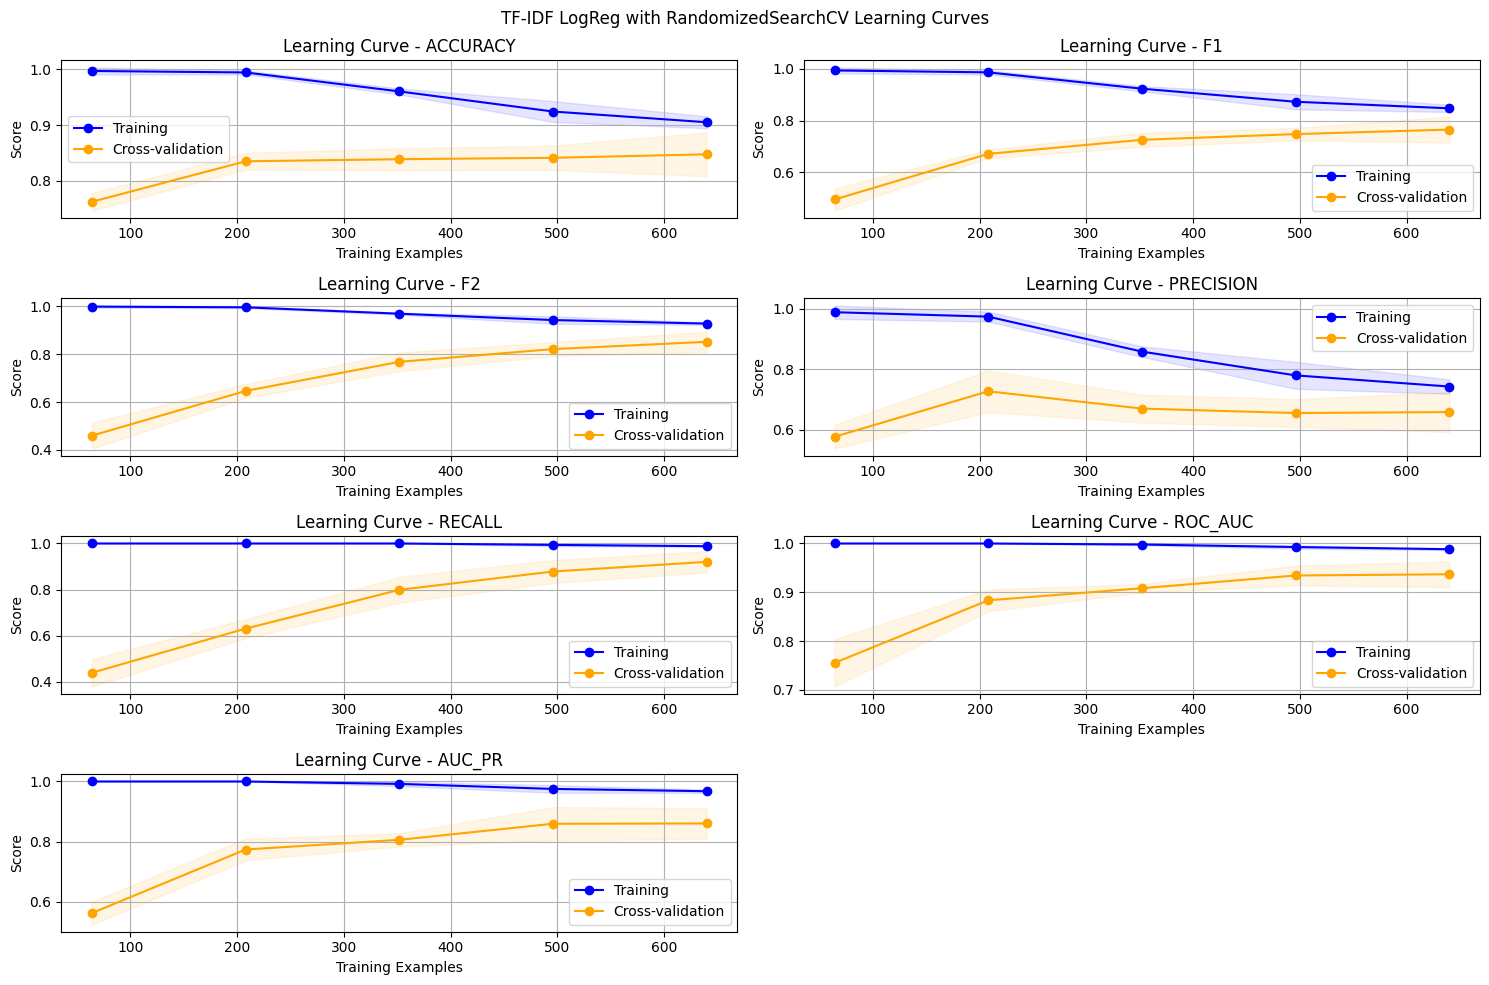


Final Threshold: 0.45

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       146
           1       0.59      0.89      0.71        54

    accuracy                           0.81       200
   macro avg       0.77      0.83      0.78       200
weighted avg       0.85      0.81      0.81       200

Additional Metrics:
Accuracy   0.805
F2-score   0.808
AUC-ROC    0.900
AUC-PR     0.802



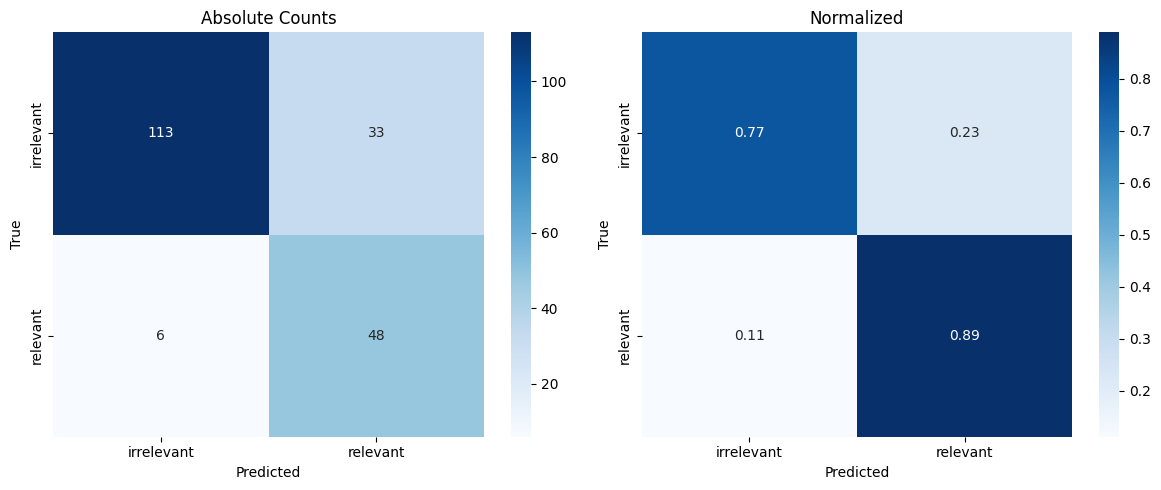

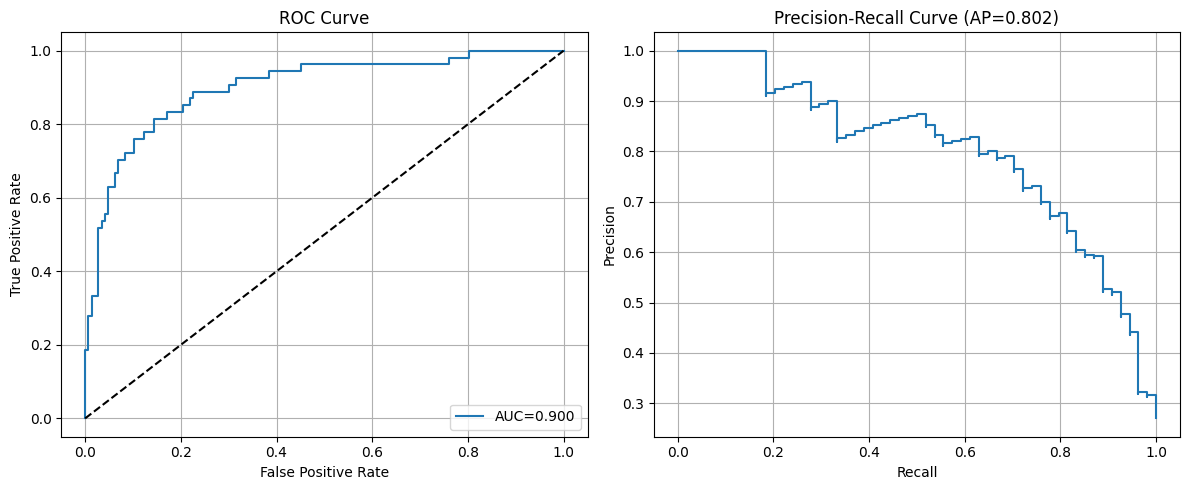


Model saved as 'model_tfidf_logreg_advanced.joblib'


In [ ]:
# Base Pipeline 
# Note: standard tfidf vectorization value for token_pattern='(?u)\\b\\w\\w+\\b' includes '_' as part of token
# so that multiword_groups are not split into single words (advanced preprocessing)
pipeline_tfidf_logreg_advanced = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)), 
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     LogisticRegression(
                    solver="liblinear",
                    penalty="l1",
                    class_weight="balanced",
                    random_state=42
                ))
])

# Hyperparameter Distributions for Random Search
# This approach scales better to different model types
weights = ["balanced"] + [{0:1, 1:w} for w in range(1, 31, 2)]
param_dist_tfidf_logreg_advanced = {
    "clf__C":            loguniform(1e-3, 1e3),      # C ∈ [1e-3, 1e3]
    "select__k":         randint(50, 151),           # k ∈ {50, …, 150}
    "clf__class_weight": weights  # class weights for cost-sensitive learning
}

# F2 Scorer and CV Strategy
f2_scorer = make_scorer(fbeta_score, beta=2)
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV (100 random configurations)
# Advantage: Easily adaptable to different models without manual grid tuning
rand_search = RandomizedSearchCV(
    estimator         = pipeline_tfidf_logreg_advanced,
    param_distributions = param_dist_tfidf_logreg_advanced,
    n_iter            = 100,
    cv                = cv,
    scoring           = f2_scorer,
    n_jobs            = -1,
    random_state      = 42,
    verbose           = 1,
    return_train_score=True
)

# Execute search
rand_search.fit(X_dev, y_dev)
print("Best parameters:", rand_search.best_params_)
print(f"Best F2 score during CV: {rand_search.best_score_:.3f}")

# Extract best model
model_tfidf_logreg_advanced = rand_search.best_estimator_

# Out-of-fold predictions for threshold tuning
y_dev_proba = cross_val_predict(
    model_tfidf_logreg_advanced, X_dev, y_dev,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Threshold tuning on dev set (optimized for F2)
dev_thresh_results = evaluate_thresholds(y_dev, y_dev_proba)
best_threshold   = max(dev_thresh_results, key=lambda r: r["f2"])["threshold"]
plot_threshold_curves(dev_thresh_results)
plt.title(f'Optimal Threshold on Dev Set: {best_threshold:.2f}')
plt.show()

# Learning curves analysis
plot_learning_curves(
    model_tfidf_logreg_advanced, X_dev, y_dev,
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LogReg with RandomizedSearchCV Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set
y_test_proba = model_tfidf_logreg_advanced.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= best_threshold).astype(int)

print(f"\nFinal Threshold: {best_threshold:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Save the RandomizedSearch model (preferred for template/comparison purposes)
# This approach is more generalizable across different model types
dump({
    'model': model_tfidf_logreg_advanced,
    'threshold': best_threshold,
    'cv_score': rand_search.best_score_,
    'best_params': rand_search.best_params_,
    'search_type': 'RandomizedSearchCV'
}, "model_tfidf_logreg_advanced.joblib")

print(f"\nModel saved as 'model_tfidf_logreg_advanced.joblib'")


**experimental visualizations and test if joblib.load works**

INTERESTING: ontras_gastransp is a negative valued feature, although every document with this term was labeled as relkevant by the author

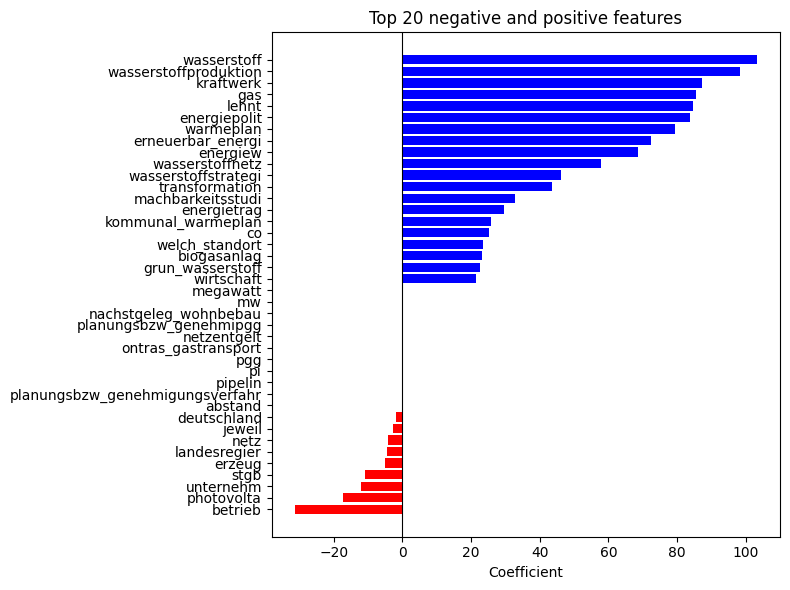

In [10]:
from joblib import load

# load model
data = load("model_tfidf_logreg_advanced.joblib")
model      = data['model']
threshold  = data['threshold']
cv_score   = data['cv_score']
best_params= data['best_params']

# plot coefficients
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tfidf  = model.named_steps['tfidf']
select = model.named_steps['select']
clf    = model.named_steps['clf']

all_feats = tfidf.get_feature_names_out()
sel_feats = all_feats[select.get_support()]
coefs     = clf.coef_[0]

df_coef = pd.DataFrame({'feature': sel_feats, 'coef': coefs}).sort_values('coef')
neg20 = df_coef.head(20)
pos20 = df_coef.tail(20)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(neg20['feature'], neg20['coef'], color='red')
ax.barh(pos20['feature'], pos20['coef'], color='blue')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Top 20 negative and positive features')
ax.set_xlabel('Coefficient')
plt.tight_layout()
plt.show()
